In [21]:
import gc
import numpy as np
import pandas as pd
import yfinance as yf
import back_testing as bt
import matplotlib.pyplot as plt

gc.collect()

4777

In [22]:
weight_df = pd.read_csv('data/weight_df.csv', index_col=0)
tic_df = pd.read_csv('data/tic_df.csv', index_col=0)
returns_df = pd.read_csv('data/returns_df.csv', index_col=0).loc[weight_df.index]
returns_df.index = pd.to_datetime(returns_df.index)
weight_df.index = pd.to_datetime(weight_df.index)
equal_weight_df = pd.DataFrame(1 / len(weight_df.columns), index=weight_df.index, columns=weight_df.columns)

weight_dict={}
weight_dict['Equal'] = equal_weight_df
weight_dict['Dynamic'] = weight_df

설정:
  - 기본 수수료: 10bp
  - Turnover 배수: 1
  - 리밸런싱 주기: A


[*********************100%***********************]  1 of 1 completed


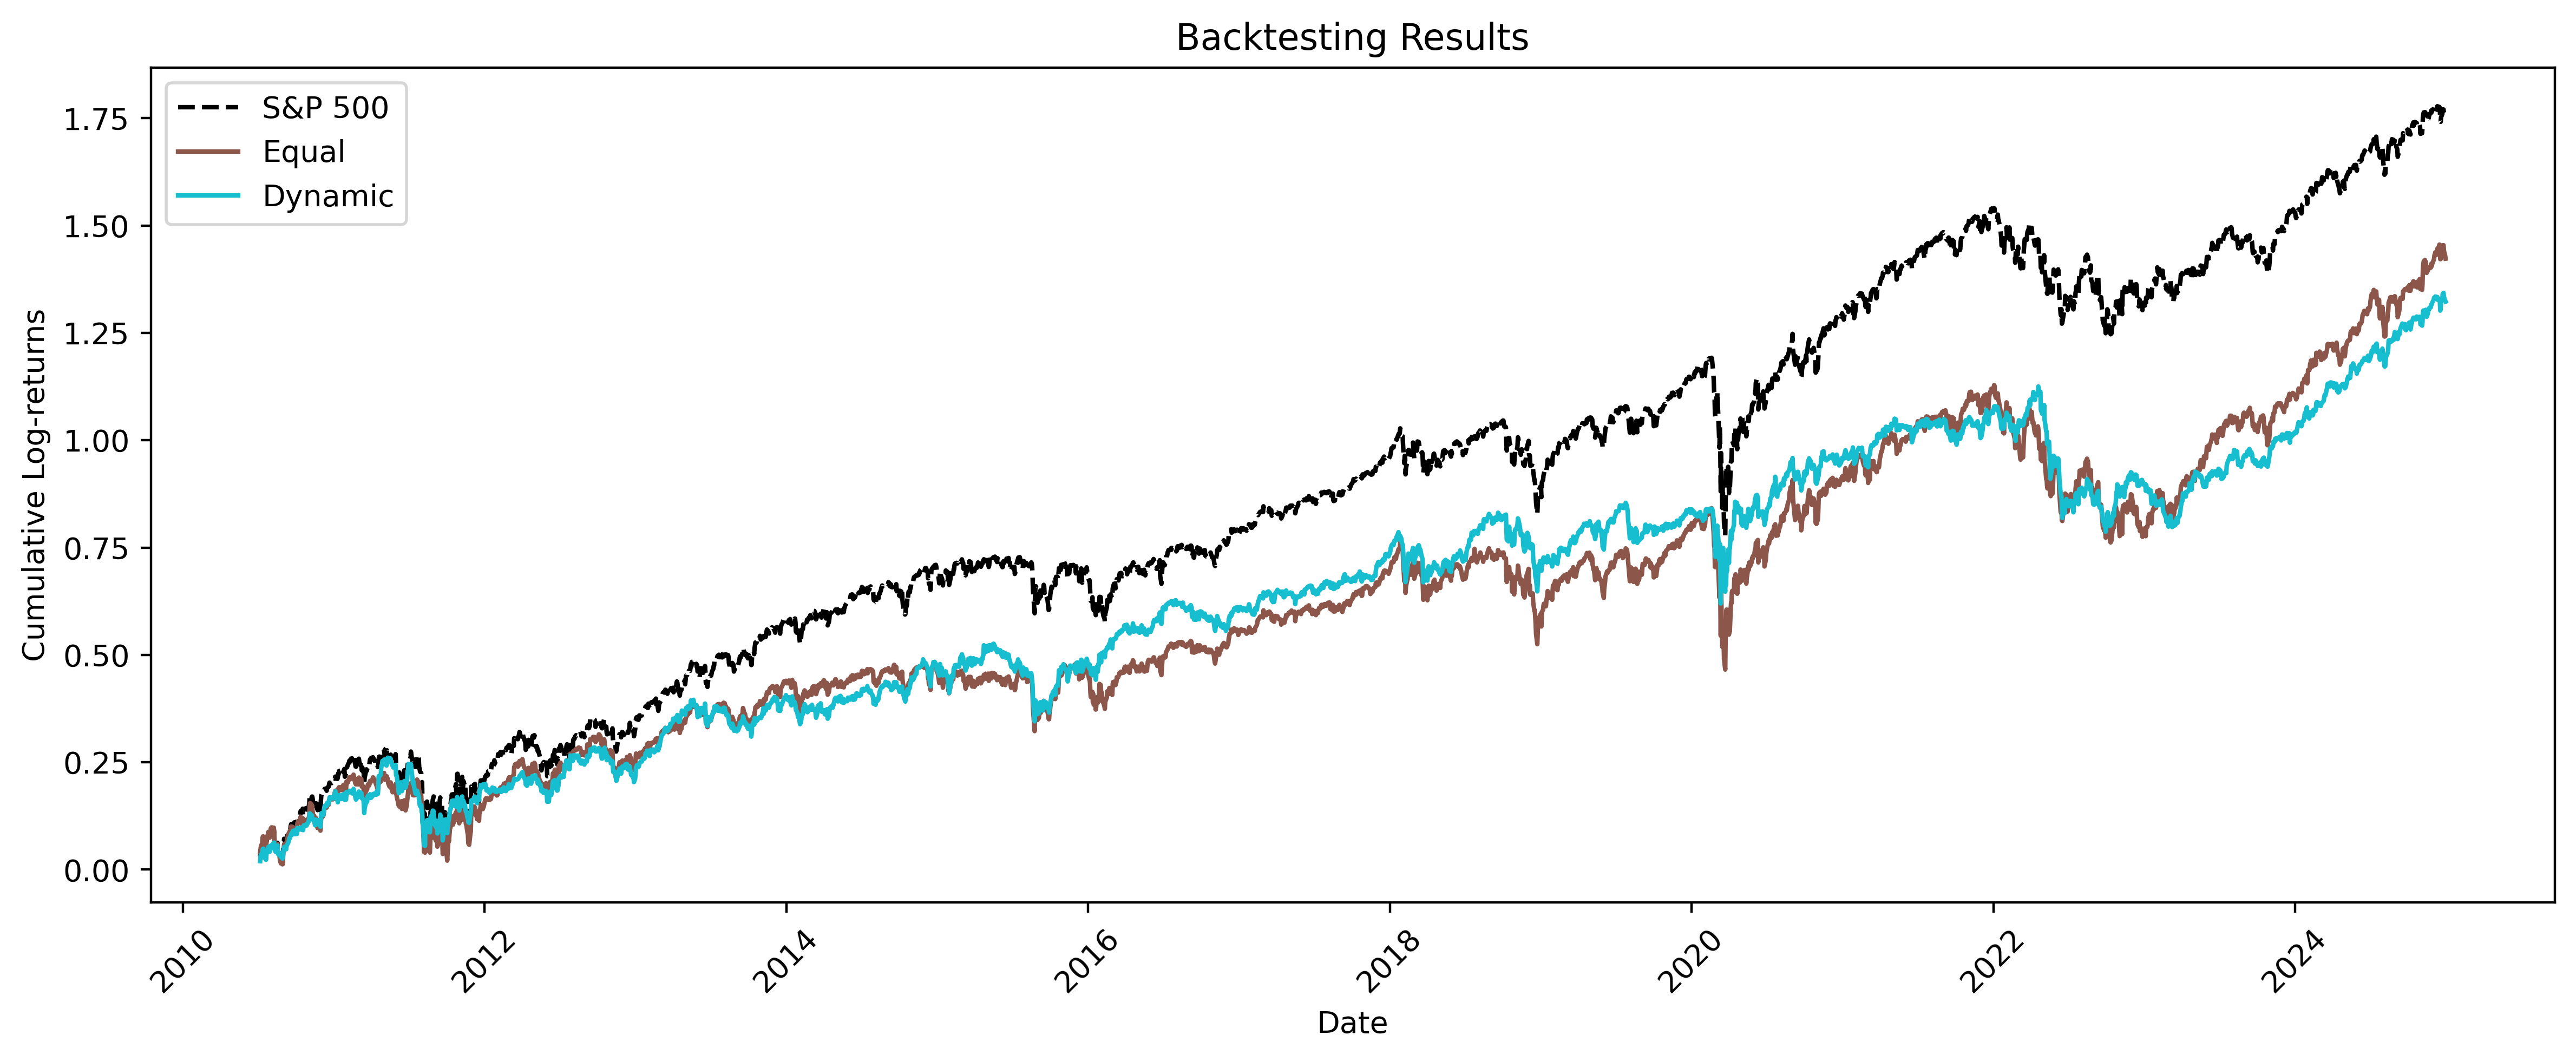

In [30]:
# 백테스팅 설정
base_fee = 0.001  # 기본 수수료 0.2%
turnover_multiplier = 1  # turnover에 따른 수수료 증가 배수
rebalance_freq = 'A' # 적응형 리벨런싱 주기

print(f"설정:")
print(f"  - 기본 수수료: {base_fee*10000:.0f}bp")
print(f"  - Turnover 배수: {turnover_multiplier}")
print(f"  - 리밸런싱 주기: {rebalance_freq}")

# 백테스팅 실행
result_df = pd.DataFrame()
for str_name in weight_dict.keys():

    result_df = bt.return_Table(
        weight_dict[str_name], 
        returns_df,  # 가격 데이터 직접 전달
        result_df,
        rebalance_freq=rebalance_freq,
        fee=base_fee,
        turnover_multiplier=turnover_multiplier,
        tic_df=tic_df
    )
    
# 컬럼명 설정 (S&P 500 + 전략들)
result_df.columns = ['S&P 500'] + list(weight_dict.keys())

bt.plot_result(result_df)

In [24]:
out = bt.compute_turnover_and_fee(base_fee, turnover_multiplier, weight_dict['Equal'], 'A', tic_df)
print(f"Equal: {out['turnover'].mean():.4f}")
print(f"Equal: {out['fee_log'].sum():.4f}")

out = bt.compute_turnover_and_fee(base_fee, turnover_multiplier, weight_dict['Dynamic'], 'A', tic_df)
print(f"Dynamic: {out['turnover'].mean():.4f}")
print(f"Dynamic: {out['fee_log'].sum():.4f}")

Equal: 0.0021
Equal: -0.1319
Dynamic: 0.0287
Dynamic: -0.2820


In [25]:
metric = bt.METRICS(result_df.dropna())
metric.cal_describe()
metric.cal_monthly_statistics()

In [26]:
metric.annual_statistics

,S&P 500,Equal,Dynamic
Date,2010-07-07 ~ 2024-12-31,2010-07-07 ~ 2024-12-31,2010-07-07 ~ 2024-12-31
count,3647,3647,3647
cumulative return,474.57148,311.04759,274.55055
annualized return mean,0.12842,0.1026,0.09554
annualized return std,0.18733,0.19182,0.15421
annualized return downside std,0.15367,0.1544,0.11765
sharpe ratio,0.68551,0.53489,0.61957
sortino ratio,0.83564,0.66454,0.81208
gross profit,13.91815,14.1258,11.75336
gross loss,-12.1697,-12.71226,-10.43281


In [27]:
metric.monthly_statistics

,S&P 500,Equal,Dynamic
Mean,0.00048,0.00039,0.00036
Standard deviation,0.01082,0.01105,0.00903
Standard error,0.00018,0.00018,0.00015
t-statistic,2.9139,2.3364,2.6302
Min,-0.12765,-0.12686,-0.08486
25%,-0.00376,-0.00409,-0.00349
50%,0.00067,0.00061,0.00032
75%,0.00568,0.00582,0.00482
Max,0.08968,0.10069,0.10191
Skew,-0.75011,-0.59784,-0.08147


In [28]:
metric.save_results('./general_results')